# RA Diagnosis Extraction with Machine Learning
This notebook is built for extracting the diagnosis from format-free textfields of Electronic Medical Health records. 
- Feel free to make some adjustments that better correspond with your data

In [3]:
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append('/exports/reum/tdmaarseveen/modules')
from scipy import __version__ as sc_vers
from yellowbrick import __version__ as yb_vers
from sklearn import __version__ as sk_vers
import buildingAClassifier as bc
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
import re
import random
import pickle
import xgboost as xgb

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('scipy version:\t\t' + sc_vers)
print('pattern version:\t' + pat_vers)
print('yellowbrick version:\t' + yb_vers)
print('xgb version:\t' + xgb.__version__)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.17.0
sklearn version:	0.21.2
scipy version:		1.1.0
pattern version:	3.6
yellowbrick version:	0.9.1
xgb version:	0.90


## Step 1: Cleaning Data with NLP methods
Applying Natural Language Processing algorithms:
- Word segmentation: words are split on whitespace -> special characters are removed
- lemmatization: words are returned to the root form (if word is in corpus) - default= Dutch (nl)
- Typocorrection
- XML artefact removal

The aforementioned functions can be useful, depending on the quality of the data

### 1.1 Open file
In our data we have the following columns: 
- XANTWOORD= free text field from the EMR (Conclusion)
- Outcome= associated label

In [72]:
radiag_df = pd.read_csv(r'data/annotation_v2_20190125.csv', sep='|')
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x: 'y' if x == 'j' else 'n')
radiag_df[['XANTWOORD', 'Outcome']].head()

,XANTWOORD,Outcome
0,psoa in remissie,n
1,1 . slotklachten beide knieen dd meniscusprobl...,n
2,polyartritis,n
3,"1 . artritis psoriatica , twee gewrichten onst...",n
4,rustige jia ^meerdere ok ' s te radbout zh,n


### 1.2 Create Dutch dictionary for EMR
1. Source for dictionary files (multiple languages) - https://github.com/titoBouzout/Dictionaries 
2. If left unchanged this step only applies if you're working with Dutch data

In [ ]:
def readDictionary(location):
    return list(pd.read_csv(location, sep='/').index)

l_custom= list(pd.read_csv('corpus/Custom.dic', sep=';')) # custom dutch clinical vocab
l_dutch= readDictionary('corpus/Dutch.dic') # dutch dictionary

l_dutch.extend(l_custom) # combine dutch dictionary with the custom dict
l_new = [bc.removeAccent(bc.processArtefactsXML(i)) for i in l_dutch]
print('Dic:\t\t\t', str(len(l_new)))
l_new = [i for i in l_new if i.lower() == i]
l_new = [i for i in l_new if len(i) > 2]
print('Dic (names removed):\t', str(len(l_new)))

### 1.3 Preprocessing - Word segmentation and lemmatizing 
The typo correction step is currently muted on purpose, because this step only applies if you're working with Dutch data

In [11]:
import importlib as imp
imp.reload(bc)
import time

radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.processArtefactsXML(str(x)))
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x, lemma=False))

# Apply TypoCorrection  
  #  typocor = bc.TypoCorrection(np.array(l_new)) # provide word list
  #  t0 = time.time()
  #  radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : typocor.correct(x))
  #  t1 = time.time()
  #  print('Time for TypoCorrection (n=' + str(len(radiag_df)) + ') : ' + str(t1-t0))

radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.lemmatizingText(x, lan='nl')) # 'en' for english & 'de' for german
radiag_df=radiag_df.fillna('')

# Save autocorrected dataframe
radiag_df.to_csv(r'data/autocorrect_emr.csv', sep='|', index=False)

## Step 2: Structuring the data

### 2.1 Open the preprocessed dataset

In [12]:
radiag_df = pd.read_csv(r'data/autocorrect_emr.csv', sep='|')
radiag_df[['XANTWOORD', 'Outcome']].head()

,XANTWOORD,Outcome
0,psoa in remissie,n
1,slotklacht beide knie dd meniscusprobleem eerd...,n
2,polyartritis,n
3,artritis psoriatica twee gewricht onstook ferr...,n
4,rustig jia meerdere ok te radbout zh,n


### 2.2 Balancing classes in data (Proportion RA cases vs. non cases) - Optional
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 
- Optional: Whether or not you want to balance the classes depends on the expected prevalence of the cases in the test data. 
- You could also choose to balance the classes in a different way (eg: 1:5) but it should always correspond with the expected prevalence in the test set. Choose the desired nr of samples by changing nr_of_samples

Default: False

In [5]:
balance = False
nr_of_samples = len(radiag_df[radiag_df['Outcome']=='y'])

if (balance):
    df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(n=nr_of_samples, random_state=SEED)
    equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
    radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 2.3 Splitting annotated set on both the textual data and the corresponding label (Y)

In [13]:
X = radiag_df['XANTWOORD'].values
y = radiag_df['Outcome'].values
y_b = np.array([bc.binarize(val) for val in y])

### 2.4 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

(439, 922)


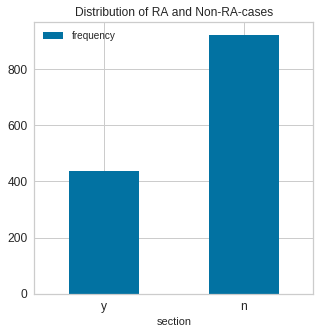

In [14]:
from collections import Counter

labels, values = zip(*Counter(y).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


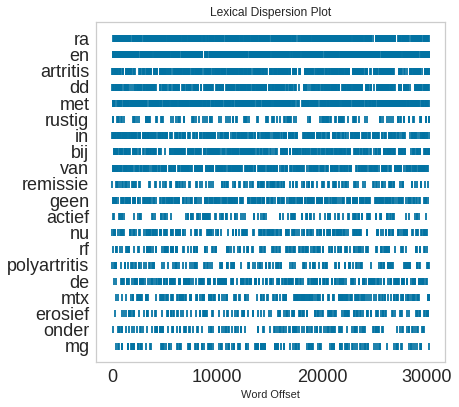

In [15]:
import importlib
importlib.reload(bc)

bc.plotLexicalDispersion(X, nr_features=20, ngram_range=(1,1))

#### Plot: Feature distribution

<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

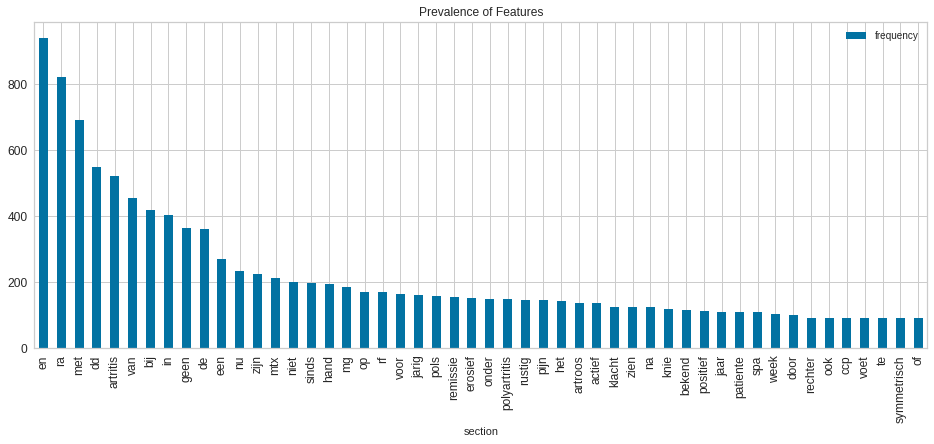

In [16]:
bc.plotSampleDistribution(X, nr_features=50) 

## Step 3: Building the Pipeline
import all of the classifiers that you want to apply/compare

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
# from xgboost import XGBClassifier

### 3.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [18]:
SEED=777
import sklearn.ensemble as ske
pipe_list = [
    # Naive Bayes - 0
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 4 - NuSVC probability
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=SEED)),
            ]),
    # Random Forest 5
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 6
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', DummyClassifier(random_state=SEED)),
            ]),
    ]

### 3.2 Initialize the Word Matching Method
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra' (Dutch)

In [20]:
l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']
WordMatching = bc.CustomBinaryModel(l_targets)

## Step 4: Compare classification models
Keep in mind: In the current implementation: the models are re-assembled every time (identical fits) you create a ROC or PR-curve -> This is quite a heavy time-process. I am currently working hard to optimize the code

### 4.1 ROC-AUC
Visualize performance of the models in ROC curve

- Note: the ROC curve of the decision tree estimator cant be assessed with the standard plotCrossValidationROC function, because it doesn't calculate the probabilities. Therefore, the function plotBinaryROC is utilized to estimate the decision tree ROC. 

Word Matching 0.7823000262099927 (std : +/-0.015603187531642804 )
Decision Tree 0.8228637623799497 (std : +/-0.0156669573371902 )
Train-score Decision Tree 0.9947170992376472 (std : +/-0.0005630877094774187 )
Naive Bayes 0.8499850317474988 (std : +/-0.008123220817414546 )
Train-score Naive Bayes 0.9944928750372309 (std : +/-0.0009276167262711312 )
Gradient Boosting 0.943666294821475 (std : +/-0.009460675090803998 )
Train-score Gradient Boosting 0.994949494949495 (std : +/-0.0005163840488102271 )
Neural Networks 0.9237037732011789 (std : +/-0.013070669226637894 )
Train-score Neural Networks 0.9936535162950257 (std : +/-0.00401231138432564 )
SVM 0.9319603492966986 (std : +/-0.005621817411093125 )
Train-score SVM 0.994949494949495 (std : +/-0.0005101008264577013 )
Random Forest 0.8987570997686899 (std : +/-0.017203863643161836 )
Train-score Random Forest 0.9949067527211708 (std : +/-0.000305243499875657 )
Dummy 0.4905424661336787 (std : +/-0.01583525307490022 )
Train-score Dummy 0.4918613

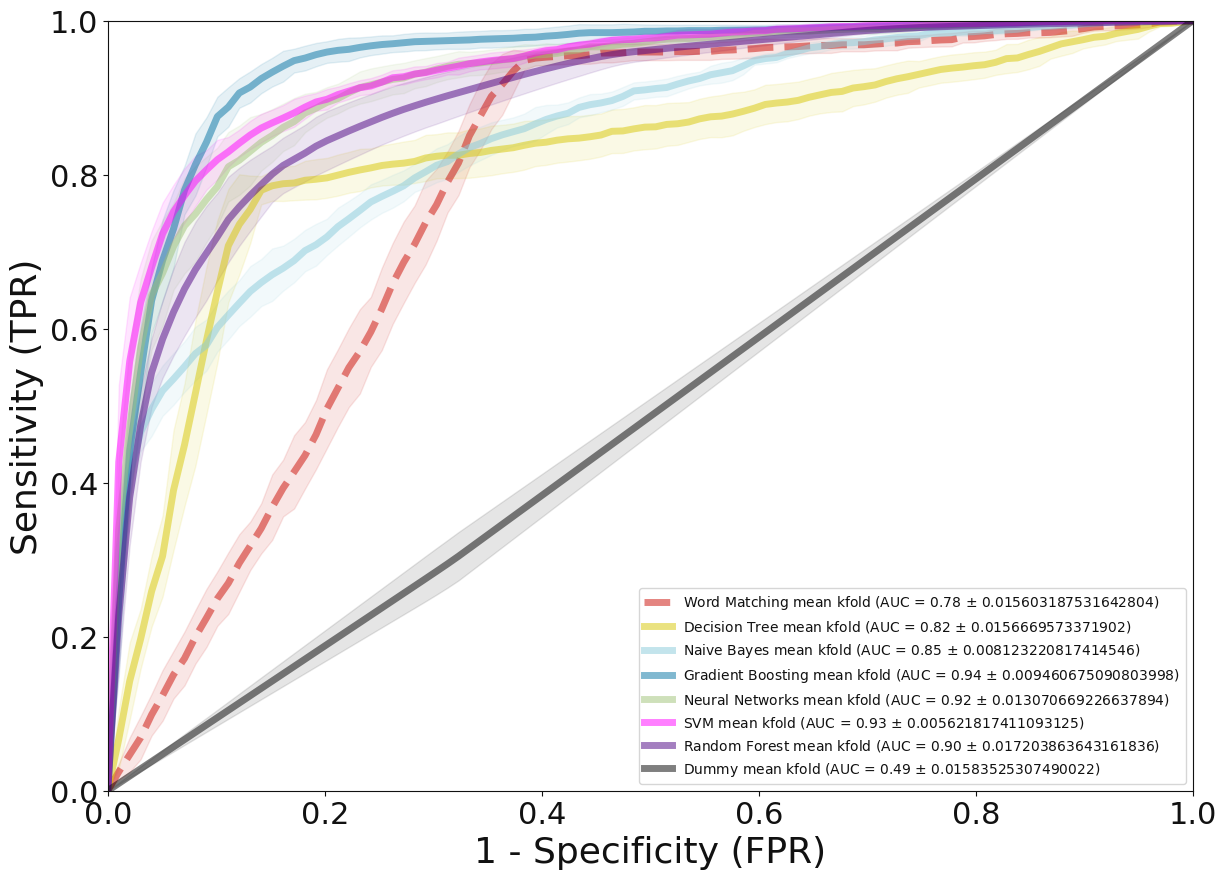

In [38]:
import importlib
import matplotlib.pylab as pylab
importlib.reload(bc)
import matplotlib as mpl
mpl.style.use('default')


lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'SVM', 'Random Forest', 'Dummy'] 

l_folds = bc.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:7] # exclude decision -> because it cant assess the probabilities!
params = {'legend.fontsize': 10,
          'figure.figsize': (14,10),
          'axes.grid': False,
         'axes.labelsize': 26,
         'axes.titlesize':'xx-small',
         'xtick.labelsize':22,
          'axes.labelcolor' : 'k',
          'ytick.color' : 'k',
          'xtick.color': 'k',
        'font.weight':'regular',
         'ytick.labelsize':22}
pylab.rcParams.update(params)
plt.figure()

plt, ref_auc, auc_ref, fitted_wm = bc.plotCustomModelROC(WordMatching, X, y, l_folds, 'Word Matching', 'r', '--') # custom made roc
plt, dt_auc, auc_dt, fitted_dt = bc.plotBinaryROC(pipe_list[3], 'Decision Tree', X, y, l_folds, 'y')
plt, d_aucs, fitted_models = bc.plotCrossValidationROC(filtered_pipe,'ROC curve for different classification methods', lbls, X, y, l_folds, ref_auc)

plt.savefig('figures/results/ROC_curve_all_methods.png', bbox_inches='tight')

#### 4.1.1 Student's T-Test relative to Naive Word Matching
Evaluate the difference in performance by applying a t-test

- auc_ref = ROC- Area under the curve of the naive Word Matching method
- d_aucs = dictionary with all of the aucs 

In [12]:
import scipy

for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

# classifiers without probabilities
print('Decision Tree\t(p =', scipy.stats.ttest_ind(auc_dt, auc_ref)[1], ')')

Gradient Boosting 	(p = 5.7253541106509124e-12 )
Naive Bayes 	(p = 3.347155860244327e-12 )
SVM 	(p = 1.2896984319202858e-11 )
Dummy 	(p = 6.615316740180759e-22 )
Neural Networks 	(p = 2.251982989090396e-11 )
Random Forest 	(p = 1.330283203441852e-05 )
Decision Tree	(p = 0.04151081725559506 )


### 4.2. AUC - Precision Recall curve

Word Matching 0.3618198373099902 (std : +/-0.06988321696853232 )
Train Decision Tree 0.9931027446178962 (std : +/-0.0006270407943095102 )
Decision Tree 0.4943594088377692 (std : +/-0.07556223379351008 )
Train Naive Bayes 0.8938756023317612 (std : +/-0.019722728534544025 )
Naive Bayes 0.3265445758492926 (std : +/-0.03943026496227888 )
Train Gradient Boosting 0.9931027446178962 (std : +/-0.0006270407943095102 )
Gradient Boosting 0.8670254407063952 (std : +/-0.021858337718316512 )
Train Neural Networks 0.9931027446178962 (std : +/-0.0006270407943095102 )
Neural Networks 0.8685783748346201 (std : +/-0.025647875153913036 )
Train SVM 0.9931027446178962 (std : +/-0.0006270407943095102 )
SVM 0.8822651740145276 (std : +/-0.022527890442830125 )
Train Random Forest 0.9929942126743058 (std : +/-0.0007671545365492873 )
Random Forest 0.7380431584674461 (std : +/-0.04644916757529916 )
Train Dummy 0.0878840700966522 (std : +/-0.010951517110133806 )
Dummy 0.07567270858096624 (std : +/-0.010306361117850

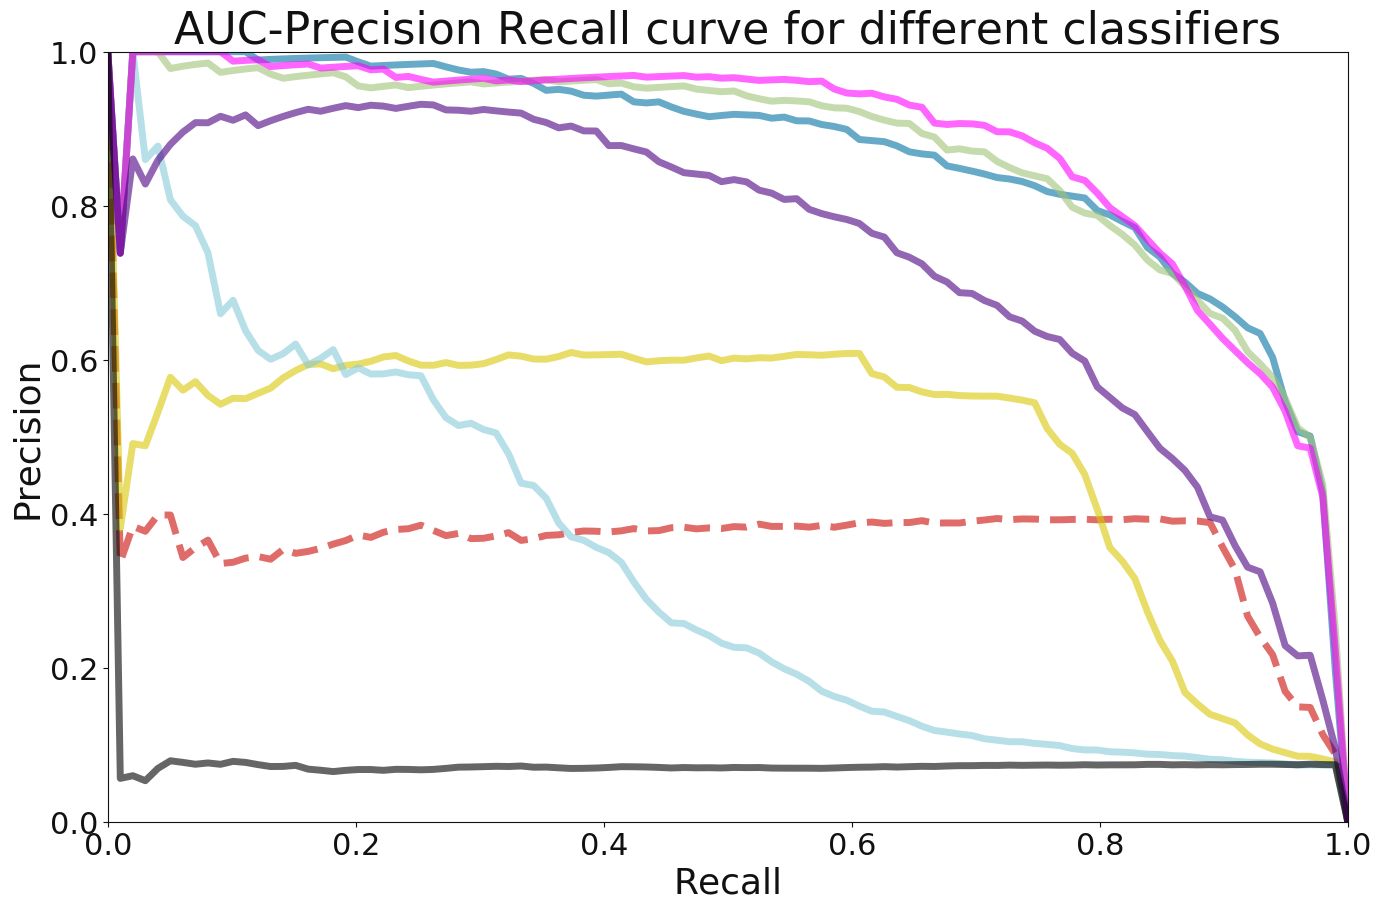

In [13]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#plt.figure(figsize=(14,8))

l_folds = bc.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:7]
lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'SVM', 'Random Forest', 'Dummy'] #   'XGBoost', 
params = {'legend.fontsize': 10,
          'figure.figsize': (16,10),
          'axes.grid': False,
         'axes.labelsize': 26,
         'axes.titlesize':'xx-small',
         'xtick.labelsize':22,
          'axes.labelcolor' : 'k',
          'ytick.color' : 'k',
          'xtick.color': 'k',
        'font.weight':'regular',
         'ytick.labelsize':22}
pylab.rcParams.update(params)
plt.figure()

colors = ['c', 'b', 'g', 'magenta', 'indigo','black', 'orange']
prev = 0.5
title = 'AUC-Precision Recall curve for different classifiers'
plt, auprcs_ref = bc.plotCustomModelPR(WordMatching, X, y, l_folds, 'Word Matching', 'r', '--') # Approximation (sorted)
plt, auprcs_dt = bc.plotBinaryPR(pipe_list[3], X, y_b, l_folds, 'Decision Tree', 'y') # Approximation (sorted)
plt, d_auprcs = bc.plotCrossValidationPR(filtered_pipe, X, y_b, l_folds, title, lbls, colors)
plt.savefig('figures/results/PR_curve_all_methods.png', bbox_inches='tight')

#### 4.2.2 Student's T-Test relative to Naive Word Matching (PR-AUC)

In [142]:
import scipy

for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_auprcs[key], auprcs_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

# classifiers without probabilities
print('Decision Tree\t(p =', scipy.stats.ttest_ind(auprcs_dt, auprcs_ref)[1], ')')

Random Forest 	(p = 8.846669328240849e-11 )
Gradient Boosting 	(p = 7.912242361923782e-14 )
SVM 	(p = 3.334401383541099e-14 )
Naive Bayes 	(p = 0.20354365827676418 )
Neural Networks 	(p = 1.0489736890308557e-13 )
Dummy 	(p = 4.117050640813359e-10 )
Decision Tree	(p = 0.002966070607428184 )


## Step 5: Distribute Model - save best classification model
With pickle you can save & load the models

In [60]:
best_model = fitted_models['SVM'] # automatically takes the median iteration
filename='savedModels/SVM.sav'
pickle.dump(best_model[2], open(filename, 'wb'))

### 5.1 Import best performing model
you can apply this model on a new unlabeled set

In [21]:
filename='savedModels/SVM.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#### 5.1.2 Example of using a previously constructed model 

In [ ]:
import pickle

model_name='savedModels/SVM.sav'
file_name='data/some_file.csv'
text_column='XANTWOORD'

# get EMR text
new_df = pd.read_csv(file_name, sep=';')
X = new_df[text_column].values

# apply built model on provided text
loaded_model = pickle.load(open(model_name, 'rb'))
probas_ = loaded_model.predict_proba(X)
pred = probas_[:,1]


# add predictions to table
new_df['prediction'] = new_df['some_column'].copy()
new_df['prediction'] = pred
new_df[['PATNR', 'RA_case_1y']].to_csv(r'validation/some_file_predictions.csv', sep='|', index=False)

## Step 6: Evaluate best Model
Retrieve the predictions/attributes of the median iteration of the Support Vector Machine

In [39]:
gbm_model = fitted_models['Gradient Boosting'] 

# Import the fitted model + fold information + the optimal cut_off
estimator = gbm_model[2] # the entire pipeline
classifier = estimator.steps[1] # only the classifier
test_index = gbm_model[3] # use this to get the test set of the k-fold
train_index = gbm_model[4] # use this to get the trainingset of the k-fold
cut_off = gbm_model[5]

# Apply the cut-off on the probabilities -> to assess the predictions
l_pred = [int(gbm_model[0][i] >= cut_off) for i in range(len(gbm_model[0]))]

### 6.1 Scatterplot visualizing the classification capabilities (probabilities)

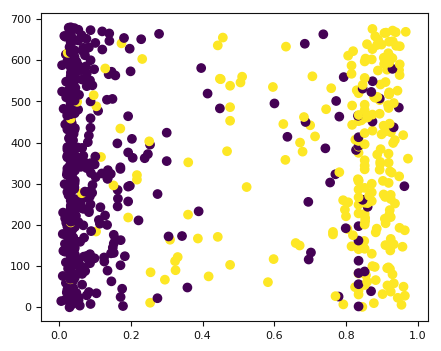

In [49]:
params = {'legend.fontsize': 4,
          'figure.figsize': (5,4),
          'axes.grid': False,
         'axes.labelsize': 8,
         'axes.titlesize':'xx-small',
         'xtick.labelsize':8,
          'axes.labelcolor' : 'k',
          'ytick.color' : 'k',
          'xtick.color': 'k',
        'font.weight':'regular',
         'ytick.labelsize':8}
pylab.rcParams.update(params)
ax = plt.scatter(x=gbm_model[0], y=list(range(len(gbm_model[0]))), c=y_b[test_index], cmap='viridis')

### 6.2 Visualize optimal cut-off

### 6.2 Optimal cut-off 
Keep in mind that this model is not optimalized yet for time-performance

#### 6.2.1. First load the models again 
Provided models are re-assembled

{'RandomForestClassifier': 'b', 'SGDClassifier': 'c'}
loading model:  SGDClassifier
nr of iterations:  10
loading model:  RandomForestClassifier
nr of iterations:  10
RandomForestClassifier 0.8149760039543599 (std : +/-0.02811422396325748 )
SGDClassifier 0.874423380883078 (std : +/-0.01641025542646167 )


<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

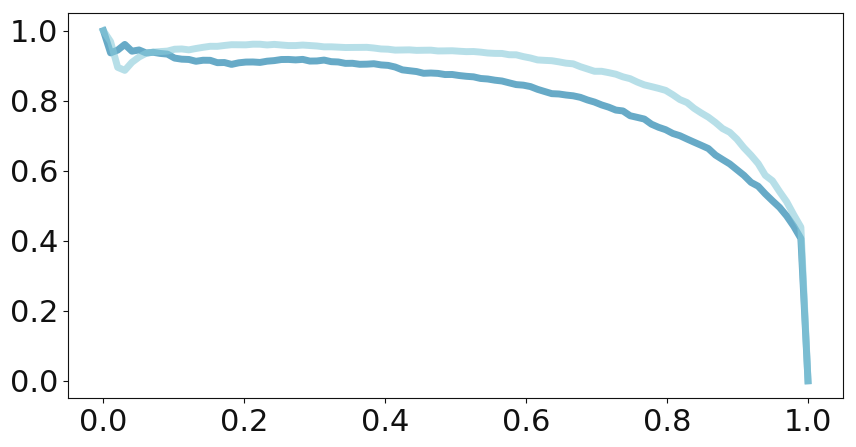

In [62]:
import TextClassification as tc
import importlib
importlib.reload(tc)

filtered_pipe = pipe_list[4:6] # SVM & RandomForest

tm = tc.TextClassification(X, y, filtered_pipe)
tm.binarizeLabel(y, true_label='y')
tm.assignPalette()
tm.fitModels()
tm.plotPrecisionRecall() # necessary to assess the median Iteration

#### Example: Optimal threshold when Sensitivity of 0.9 is desired
Returns the threshold corresponding with a sensitivity of 0.9 and the highest possible precision

Generating confusion matrix for SGDClassifier based on median Iteration (AUPRC):  4
Other weighing variables:  ['prc']
Thresh: 0.28 
PRC: 	0.68 
Sens: 	0.90 
Spec: 	0.79
Confusion matrix, without normalization
[[363  96]
 [ 22 200]]


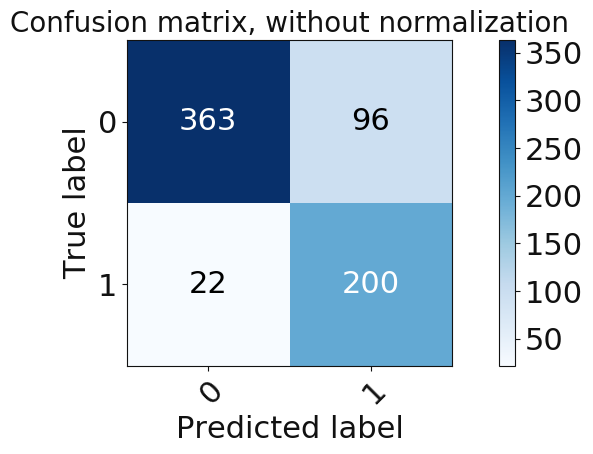

In [63]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SGDClassifier', desired=0.9, most_val='tpr')

#### Example: Optimal cut-off when Precision of 0.9 is desired
Returns the threshold corresponding with a precision of 0.9 and the highest possible sensitivity

Generating confusion matrix for SGDClassifier based on median Iteration (AUPRC):  4
Other weighing variables:  ['tpr']
Thresh: 0.56 
PRC: 	0.90 
Sens: 	0.71 
Spec: 	0.96
Confusion matrix, without normalization
[[442  17]
 [ 64 158]]


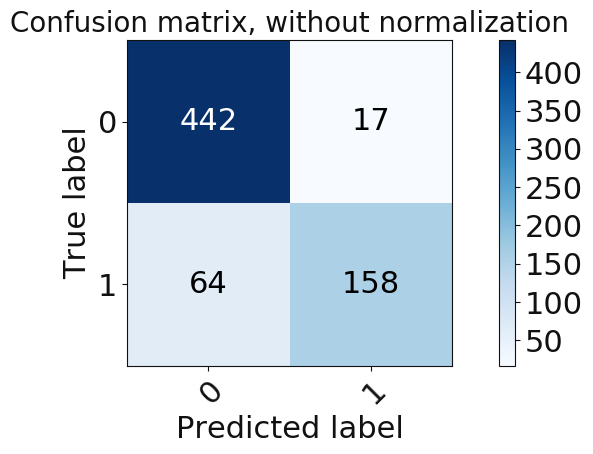

In [70]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SGDClassifier', desired=0.9, most_val='prc')

## Step 7: Visualize most important features 
Optional Visualizations -> of best model & median Fold
### 7.1 Chi-squared test of top 20 features

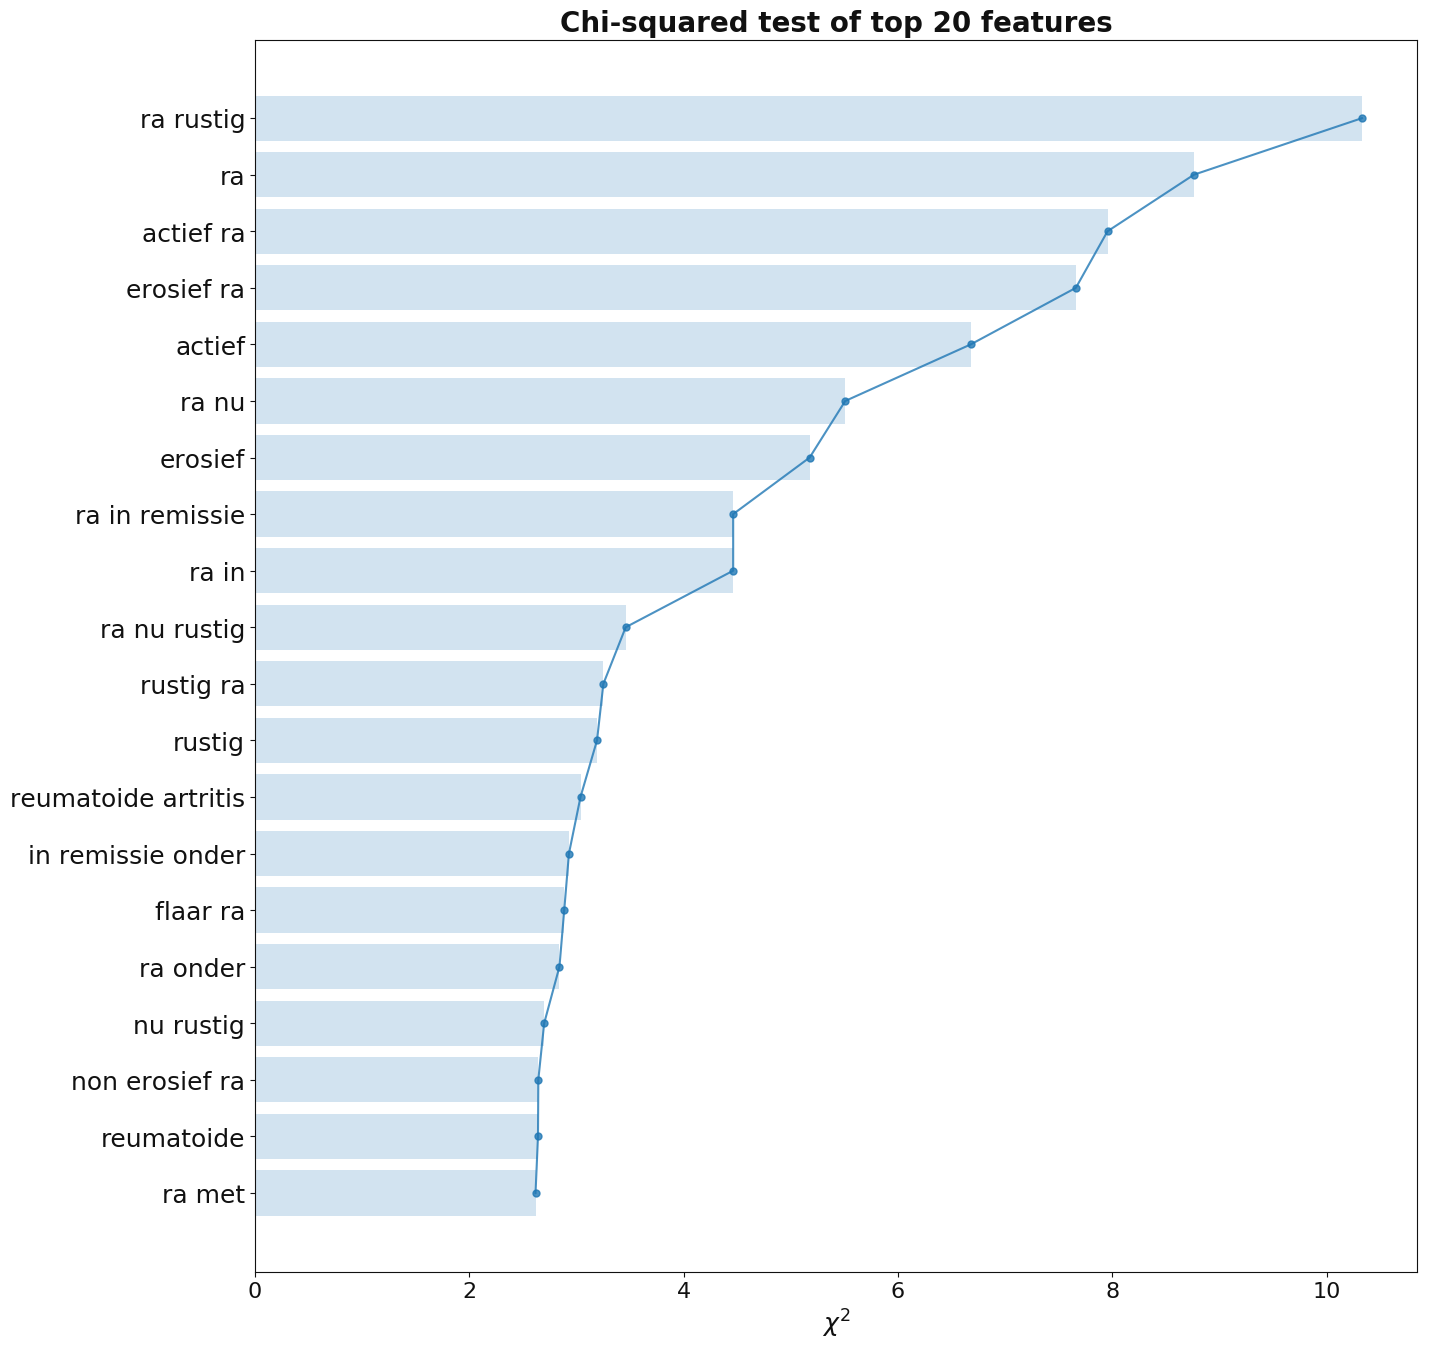

In [64]:
import importlib
importlib.reload(bc)
plt = bc.plotFeatureChiSquared(X[train_index], np.array(y)[train_index], nr_features=20, ngram_range=(1,3))

plt.show()

### 7.2 Pearson correlation per feature

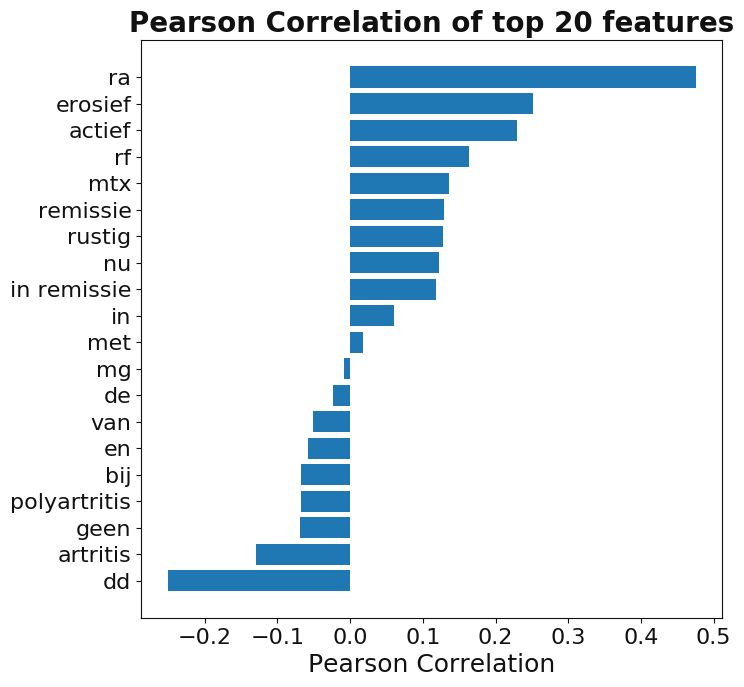

In [65]:
plt = bc.plotFeatureCorrelation(X[train_index], np.array(y_b)[train_index], nr_features=20, ngram_range=(1,3))
locs, labels = plt.yticks()  

#plt.yticks(locs, ['ra', 'erosive', 'active', 'not-active', 'on', 'rf',  'currently', 'not', 'remission', 'in', 'the', 'with', 'and', 'no', 'arthrosis', 'in case of/by', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
plt.show()

### 7.3 Explained variance per feature according to the best performing model
Feature importance is calculated with the leave-one-out method to assess the explained variance of said feature. In other words: The importance of each feature reflects the model error caused by exclusion of said feature.

- The feature importance can only be calculated for decision tree like classifiers

25191 680
[0.00796001 0.0097106  0.00983234 0.01175178 0.01191231 0.01193894
 0.01334354 0.01568426 0.01685358 0.01751165 0.01776812 0.02097782
 0.0240077  0.02440107 0.03188207 0.03451241 0.04310101 0.08744242
 0.2779161  0.31149228]


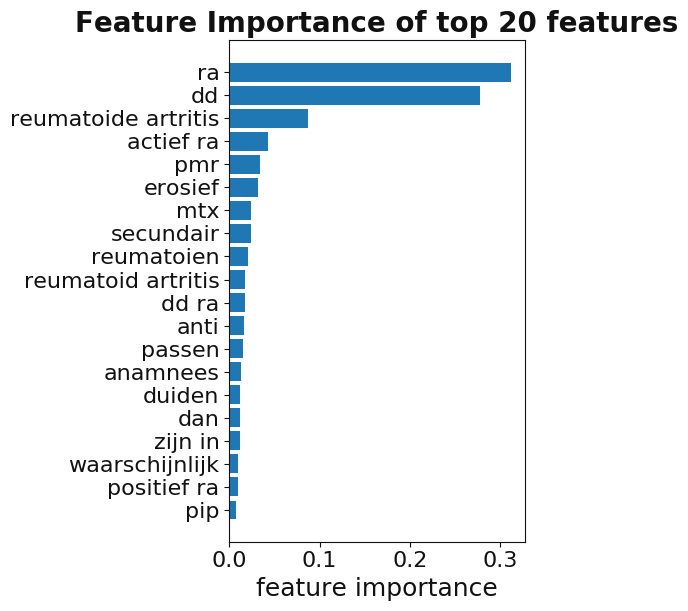

In [67]:
import importlib
importlib.reload(bc)
#params = {}#fontweight='bold'


params = {'axes.titlesize':15, 'figure.figsize': (10,7)}
pylab.rcParams.update(params)
plt = bc.plotFeatureImportance(tuple(classifier)[1], X[train_index], np.array(y_b)[train_index], nr_features=20, top=True, ngram_range=(1,3))
#plt.yticks(locs, ['ra', 'mtx', 'erosive', 'rheumatoid arthritis', 'rheumatoid', 'erosive ra', 'in',  'seropositive', 'rf', 'positive', 'ccp', 'the', 'positive erosion', 'active', 'acpa', 'ra in', 'mg', 'ra in remission', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
locs, labels = plt.yticks()

plt.show()

### 7.4 Trainingset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


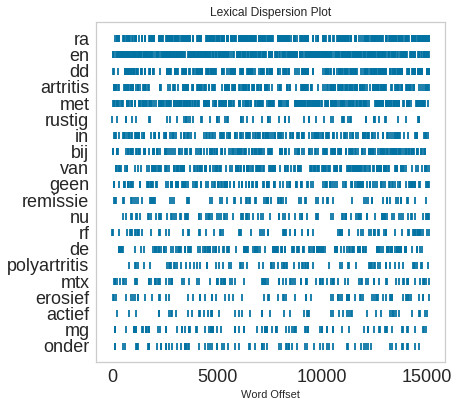

In [89]:
bc.plotLexicalDispersion(X[train_index], ngram_range = (1,1))

### 7.5 Testset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


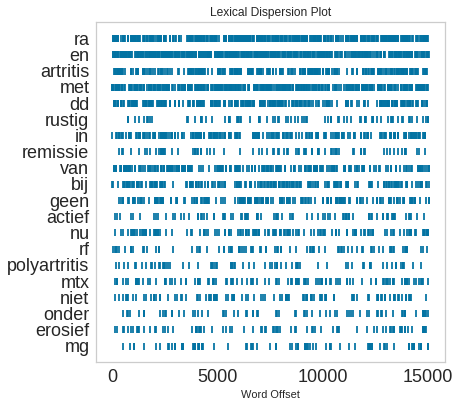

In [90]:
bc.plotLexicalDispersion(X[test_index], ngram_range = (1,1))

### 7.6 Plot distribution of n=50 prevalent features
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

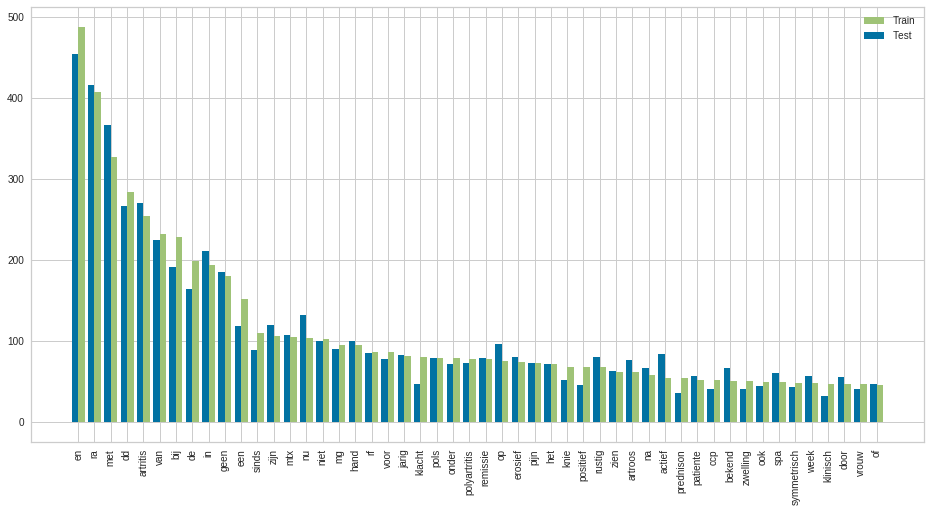

In [91]:
import matplotlib.pyplot as plt

# Assess most prevalent features
bc.plotTrainTestDistribution(X[train_index], X[test_index], nr_features=50) 

### 7.7 Graphviz | Write GBM structure to 
Outputs a file that can be visualized in http://viz-js.com/ 
##### Input:
- sub_tree = specify the subtree to draw (0-99 in this case)

In [ ]:
sub_tree = 99

test_clf = tuple(classifier)[1] # get classifier
tree2 = test_clf.estimators_[sub_tree, 0] 
lbls = tuple(estimator.steps[0])[1].get_feature_names()
bc.exportTreeGraphViz(X[train_index], tree2, lbls, 'GBM_structure_subtree' + str(sub_tree))